# Recommender system project:
Code based on a tutorial by Agnes Johannsdottir using MovieLens data set.  
Here I use the million song data set from Kaggle.




# P1: Item Similarity

In [198]:
%matplotlib inline

/Users/alexandersatz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [200]:
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn import cross_validation as cv

In [54]:
def countNonZeroEntries(matrix):
    m = np.zeros(matrix.shape[0])
    for x in range(0, matrix.shape[0]):
        m[x] = len(matrix[x][matrix[x]!=0])
    return m

In [55]:
def normalizeRowsToOne(matrix):
    m = np.zeros(matrix.shape[0])
    for x in range(0, matrix.shape[0]):
        m[x] = len(matrix[x][matrix[x]!=0])
    return m

In [56]:
def replaceNANwithZero(matrix):
    m = np.zeros((matrix.shape[0], matrix.shape[1]))
    for x in range(0, matrix.shape[0]):
        matrix[x] = np.nan_to_num(matrix[x])
    return m
    

In [57]:
def normalize1(similarity):
    '''sum similarities for each row'''
    n = np.array([np.abs(similarity).sum(axis=1)]) 
    for x in range(0, len(n[0])):
        if n[0][x] < 1:
            n[0][x] = 1         
    return n

In [58]:
def normalize(pred, countratingsperrow):
    '''by count of non-zero ratings per row'''
    for row in range(0, pred.shape[0]):
        for col in range(0, pred.shape[1]):
            if pred[row,col] != 0:
                pred[row,col] = pred[row,col]/countratingsperrow[row]
    return pred

In [59]:
def normalize2(pred, normMatrix):
    '''by norm sim value to 1; only using cases where dot product is non-zero'''
    for row in range(0, pred.shape[0]):
        for col in range(0, pred.shape[1]):
            if pred[row,col] != 0:
                pred[row,col] = pred[row,col]*normMatrix[row,col]
    return pred

In [60]:
def getNormMatrix(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for c in range (0, similarity.shape[0]):
        for r in range (0, ratings.shape[0]):
            new = similarity[c]*ratings[r]
            i = np.nonzero(new)
            nzero = np.sum(similarity[c][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1
        

In [61]:
def convertToMinOne(m):
    for r in range(0, m.shape[0]):
        for c in range(0,m.shape[1]):
            if m[r][c] < 1:
                m[r][c] = 1
    return m
              

In [62]:
def transferKnownvalues(p,test):
    for r in range(0, test.shape[0]):
        for c in range(0,test.shape[1]):
            if test[r][c] != 0:
                p[r][c] = test[r][c]
    return p
    

Below are 4 different prediction methods, each with a different way to normalize.

In [63]:
#predict(train_data_matrix, user_similarity, type='user')
def predict(ratings, similarity, type='user'):
    '''orginal predict fuction, normalize by summing all similiarity numbers'''
    if type == 'user':
        pass
    elif type == 'item':
        pred = ratings.dot(similarity) / normalize1(similarity)    
    return pred

In [64]:
def predict2(ratings, similarity, type='user'):
    '''No normalization'''
    if type == 'user':
        pass
    elif type == 'item':
        countratingsperrow = countNonZeroEntries(ratings)
        pred = ratings.dot(similarity)  
    return pred

In [65]:
def predict3(ratings, similarity, type='user'):
    '''normalized, by count of nonzero ratings'''
    if type == 'user':
        pass
    elif type == 'item':
        countratingsperrow = countNonZeroEntries(ratings)
        pred = ratings.dot(similarity)  
        pred = normalize(pred, countratingsperrow)
    return pred

In [66]:
def predict4(ratings, similarity, type='user'):
    '''normalized by sum of similarity values associated with non-zero ratings and normalize to 1'''
    if type == 'user':
        pass
    elif type == 'item':
        pred = ratings.dot(similarity) 
        normMatrix = getNormMatrix(similarity, ratings)
        pred = normalize2(pred, normMatrix)
    return pred

In [67]:
def rmse(p, test):
    '''this determines the rmse for the predicted values versus the test values.  It only considers 
    real ratings in the text matrix and ignores -non-ratings- ie zeros'''
    errors = []
    for r in range(0, test.shape[0]):
        for c in range(0,test.shape[1]):
            if test[r][c] != 0:
                errors.append(float(test[r,c])-float(p[r,c]))
    errors1 =  np.asarray(errors)
    errors2 = np.mean(errors1*errors1)
    return sqrt(errors2)

Below I read in the data

In [68]:
data = []
with open("/Users/alexandersatz/Documents/Cuny/IS643_recommenderSys/project1/kaggle_visible_evaluation_triplets.txt", "r") as f:
    for line in f:
        line = line[:-1]
        line =line.split('\t')
        data.append(line)

In [69]:
de_item = defaultdict(int)
for row in data:
    de_item[row[1]] += 1
    

In [72]:
#Here I'm removing items with few reviews.
d_itemGTE5 = {}
for key, value in de_item.iteritems():
    if value > 50:
        d_itemGTE5[key] = 1

In [73]:
print len(d_itemGTE5)
print len(de_item)

4677
163206


In [74]:
shortdata = []
for x in data:
    if x[1] in d_itemGTE5:
        shortdata.append(x)

In [75]:
de_user = defaultdict(int)
for row in shortdata:
    de_user[row[0]] += 1
    

In [76]:
#Here I'm removing users with few reviews.
d_usersGTE10 = {}
for key, value in de_user.iteritems():
    if value > 20:
        d_usersGTE10[key] = 1

In [77]:
shortdata2 = []
for x in shortdata:
    if x[0] in d_usersGTE10:
        shortdata2.append(x)

In [78]:
shortdata = shortdata2

In [79]:
## So I've gone from 1.45 million rows of data to ~42,0000
print(len(data))
print(len(shortdata))

1450933
42443


In [80]:
#data from https://www.kaggle.com/c/msdchallenge/data
#the number of times a user listens to a song is tracked

#here 'rating' is number of listens to the song.
header = ['user_id', 'item_id', 'rating']
df = pd.DataFrame(shortdata, columns=header)

In [81]:
# max listen is now 10, which represents 'liking' a song
for index, row in df.iterrows():
    if int(row['rating']) > 10:
        row['rating'] = 10

In [82]:
#I need to convert each user_id to an int, and each item_id to an int.
arrayusers = df.user_id.unique()
arrayitems = df.item_id.unique()
d_users, d_items = {}, {}
c = 0
for x in arrayusers:
    c +=1
    d_users[x] = c 
c = 0
for x in arrayitems:
    c +=1
    d_items[x] = c 


In [83]:
for index, row in df.iterrows():
    df.set_value(index, 'user_id', d_users[row['user_id']])
    df.set_value(index, 'item_id', d_items[row['item_id']])

In [84]:
df.head(5)

,user_id,item_id,rating
0,1,1,5
1,1,2,1
2,1,3,1
3,1,4,1
4,1,5,1


In [85]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of items = ' + str(n_items)  

Number of users = 1750 | Number of items = 4349


In [119]:
train_data, test_data = cv.train_test_split(df, test_size=0.26)

Note that the above data split needs to give equal numbers of users in the train and test set!  Sometimes this doesn't happen and the above split needs to be repeated until it does.

In [219]:
#Create two user-item matrices, one for training and another for testing
## row number = user_id-1, column number is item_id-1, and value is the rating.
## so each row has all ratings for every movie for that user (else a zero)
n_users = train_data.user_id.unique().shape[0]
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  
    
print n_users

n_users = test_data.user_id.unique().shape[0]
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]
    
print n_users  ## make sure both matrices have same # users

1750
1750


In [121]:
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [122]:
## make simliarity matrix have diagonal of 1's not zeros
for row in range(0, (item_similarity.shape[0])):
    for col in range(0, (item_similarity.shape[1])):
        item_similarity[row,col] = 1-item_similarity[row,col]

In [123]:
item_prediction1 = predict(test_data_matrix, item_similarity, type='item')
item_prediction2 = predict2(test_data_matrix, item_similarity, type='item')
item_prediction3 = predict3(test_data_matrix, item_similarity, type='item')
item_prediction4 = predict4(test_data_matrix, item_similarity, type='item')

In [124]:
#Normalize sum of similarities for each row
print 'Item-based CF RMSE: ' + str(rmse(item_prediction1, test_data_matrix))
#No normalization
print 'Item-based CF RMSE: ' + str(rmse(item_prediction2, test_data_matrix))
#Count of actual ratings in a column, train_data_matrix
print 'Item-based CF RMSE: ' + str(rmse(item_prediction3, test_data_matrix))
#Normalize by summing the similarities and normalizing to 1, but only for those corresponding to a rating 
#in the train_data_matrix (rows are items, columns are users)
print 'Item-based CF RMSE: ' + str(rmse(item_prediction4, test_data_matrix))

Item-based CF RMSE: 3.70528523728
Item-based CF RMSE: 1.06056200883
Item-based CF RMSE: 3.33726342111
Item-based CF RMSE: 0.732113061501


In [125]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print 'The sparsity level is ' +  str(sparsity*100) + '%'

The sparsity level is 99.4%


Below we look at the RMSE if we just assumed the 'average' rating for each item

In [126]:
## for we determine the average of all ratings in the matrix, ignoring zeros since we consider them to be 'non-ratings'
s = np.sum(test_data_matrix)
c = len(np.nonzero(test_data_matrix)[0])
m = s/float(c)
## the average rating in the matrix
print m

2.87531714389


In [127]:
#create a matrix of the average
matrix_avg = np.zeros((test_data_matrix.shape[0], test_data_matrix.shape[1]))
for row in range(0, matrix_avg.shape[0]):
        for col in range(0, matrix_avg.shape[1]):
            matrix_avg[row][col] = m
print 'Item-based CF RMSE: ' + str(rmse(matrix_avg, test_data_matrix))
## the RMSE if all predictions were the average in the matrix

Item-based CF RMSE: 2.78169136487


In [202]:
i = np.nonzero(test_data_matrix)
t = test_data_matrix[i].flatten()
p = item_prediction4[i].flatten()


The Plot below shows that the predicted values track well with the 'test' values.  There might be a bit of an issue with some data points showing up at the baseline though; I think this may be due to matrix sparsity, cases when there is no overlap between ratings and similarity values.

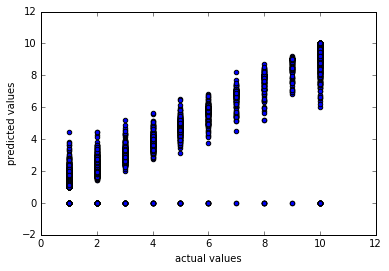

In [205]:
plt.scatter(t, p)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

# P2:  Below I try to set up on a normalized User-based CF.

In [128]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

In [129]:
## make simliarity matrix have diagonal of 1's not zeros
for row in range(0, (user_similarity.shape[0])):
    for col in range(0, (user_similarity.shape[1])):
        user_similarity[row,col] = 1-user_similarity[row,col]

In [169]:
#predict(train_data_matrix, user_similarity, type='user')
def predict_UB1(ratings, similarity, type='user'):
    '''orginal predict fuction for the UB CF as taken from the online source.  As you can see, it takes a mean user
    rating, but does not exclude zero in the average.  And it normalizes with the sum of similarities. '''
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)  # array with mean for each user
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / normalize1(similarity).T
    elif type == 'item':
        pass   
    return pred

In [165]:
def getMeanUserRating(ratings):
    l1 = []
    for x in range(0, ratings.shape[0]):
        l1.append(np.mean(ratings[x][np.nonzero(ratings[x])]))
    return np.asarray(l1)
        

In [187]:
def getNormMatrixUB(similarity, ratings):
    l1 = np.zeros((ratings.shape[0], ratings.shape[1]))
    for c in range (0, ratings.shape[0]):
        for r in range (0, similarity.shape[0]):
            new = ratings[:,c]*similarity[r]
            i = np.nonzero(new)
            nzero = np.sum(similarity[c][i])
            if nzero == 0:
                normfactor = 1
            else:
                normfactor = 1.0/nzero
            l1[r,c] = normfactor
    return l1
        

In [220]:
user_prediction1 = predict_UB1(test_data_matrix, user_similarity, type='user')

As you can see, this user based collaborative filtering still needs some help.  Mainly I think it does the normalization incorrectly, and needs a better method for dealing with some users ranking all high or low.

In [221]:
print 'User-based CF RMSE: ' + str(rmse(user_prediction1, test_data_matrix))

User-based CF RMSE: 3.75357858839
